In [1]:
import pandas as pd
from tqdm import tqdm
import ast
import math

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

tqdm.pandas()

new_events_csv = '../../generated/new_events_from_comet/ROCStories_resolved_new_triples_merged_topk_samples.tsv'
new_events_df = pd.read_csv(new_events_csv, sep='\t', header=0)

In [2]:
import numpy as np

In [3]:
forward_rels = ["xWant", "isBefore", "xEffect"]
backward_rels = ["xIntent", "isAfter", "xNeed"]


def forward_filter(triple):
    return triple[1] in forward_rels


def backward_filter(triple):
    return triple[1] in backward_rels


def get_forward_triples(triples, index):
    forward_events = []
    for triple in triples:
        if triple[1] == forward_rels[index]:
            forward_events.append(triple)
    return forward_events


def get_backward_events(triples, index):
    backward_events = []
    for triple in triples:
        if triple[1] == backward_rels[index]:
            backward_events += triple[2]
    return [a.strip() for a in backward_events]

def get_backward_embeddings(triples, index):
    backward_embeddings = np.zeros((0,384))
    print(backward_embeddings.shape)
    for triple in triples:
        if triple[1] == backward_rels[index]:
#             print(triple)
#             print(triple[3].shape)
            if triple[3].size > 0:
                backward_embeddings = np.append(backward_embeddings,triple[3],axis=0)
#                 print(backward_embeddings.shape)
    return np.array(backward_embeddings)

In [4]:
from sentence_transformers import SentenceTransformer, util

In [5]:
# def sentence_similarity(sentence1, sentence2):

#     model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#     #Compute embedding for both lists
#     embedding_1= model.encode(sentence1, convert_to_tensor=True)
#     embedding_2 = model.encode(sentence2, convert_to_tensor=True)
# # 
# #     return util.pytorch_cos_sim(embedding_1, embedding_2)

In [6]:
# sentence_similarity('to find a job', 'to have ')

In [7]:
def backward_similarity(forward_event, backward_array):
    for b in backward_array:
        if util.pytorch_cos_sim(forward_event.astype(np.float64), b.astype(np.float64)) > 0.8:
            return True
    return False

In [8]:
new_events_df = new_events_df.iloc[0:10]

In [9]:
new_events_df

Unnamed: 0                               storyid           storytitle  \
0           0  9a51198e-96f1-42c3-b09d-a3e1e067d803       Overweight Kid   
1           1  617e7ada-3878-488d-bd56-40695b91f053    The Bike Accident   
2           2  79b0da1f-e460-4173-ba58-8c9e2553c53a                Beach   
3           3  d173b7de-4611-4cdf-934c-912834755e41    The bad customer.   
4           4  af0fd5a4-de36-47ba-8aa2-e99d10986d7a        Being Patient   
5           5  5d5e7aeb-332f-4c8b-a3c3-44585501e493        Foolish Frank   
6           6  bdceebb0-c6e8-417f-b6ae-741a0a71fcd3      Shark Adventure   
7           7  a4a9aaca-d3d4-46b4-807c-ef75aea68c56  Too sunny for Sunny   
8           8  8ddc9d26-d253-4eb3-b621-9a4e6d9c57e0      The Merry Widow   
9           9  80ff5d8f-bcb1-437b-9da1-71c52997def2           Golf Cheat   

                                               sentence1  \
0                         Dan's parents were overweight.   
1            Carrie had just learned how to ride a bike.   
2                Morgan enjoyed long walks on the beach.   
3                           Jane was working at a diner.   
4                       I was talking to my crush today.   
5                          Frank had been drinking beer.   
6                   Dave was in the Bahamas on vacation.   
7                      Sunny enjoyed going to the beach.   
8  Sally was happy when her widowed mom found a new man.   
9               Dan hit his golf ball and watched it go.   

                                                           sentence2  \
0                                        Dan was overweight as well.   
1                                 She didn't have a bike of her own.   
2               She and her boyfriend decided to go for a long walk.   
3                     Suddenly, a customer barged up to the counter.   
4            She continued to complain about guys flirting with her.   
5            He got a call from his girlfriend, asking where he was.   
6                     He decided to go snorkeling on his second day.   
7  As she stepped out of her car, she realized she forgot something.   
8                  She discovered her siblings didn't feel the same.   
9              The ball bounced on the grass and into the sand trap.   

                                                              sentence3  \
0                        The doctors told his parents it was unhealthy.   
1                        Carrie would sneak rides on her sister's bike.   
2                    After walking for over a mile, something happened.   
3                  He began yelling about how long his food was taking.   
4  I decided to agree with what she says and listened to her patiently.   
5                     Frank suddenly realized he had a date that night.   
6                             While snorkeling, he saw a cave up ahead.   
7                     It was quite sunny and she forgot her sunglasses.   
8                Sally flew to visit her mom and her mom's new husband.   
9             Dan pretended that his ball actually landed on the green.   

                                                              sentence4  \
0                  His parents understood and decided to make a change.   
1                    She got nervous on a hill and crashed into a wall.   
2                           Morgan decided to propose to her boyfriend.   
3                                        Jane didn't know how to react.   
4                              After I got home, I got a text from her.   
5              Since Frank was already a bit drunk, he could not drive.   
6    He went into the cave, and he was terrified when he found a shark!   
7             Sunny got back into her car and heading towards the mall.   
8  Although her mom was obviously in love, he was nothing like her dad.   
9           His friends were not paying attention so they believed him.   

                                                            

In [10]:
sentence_transform = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [11]:
def keep_top_k_elements(l, k):
    if len(l) < k:
        return set(l)
    else:
        return set(l[:k])

In [12]:
def add_embeddings(triples):
    if isinstance(triples, float):
            pruned_triples[f-1].append([])
            return []
    
    triples_f = ast.literal_eval(triples)
    for triple in triples_f:
        embeddings = sentence_transform.encode(triple[2])
#         print(embeddings.shape)
        triple.append(embeddings)
    return triples_f

In [13]:
for f in tqdm(range(1, 6)):
    new_events_df[f'sent_w_embeddings{f}'] = new_events_df[f'sentence_{f}'].apply(add_embeddings)

100%|██████████| 5/5 [01:07<00:00, 13.45s/it]


In [14]:
n_rels = len(forward_rels)
pruned_triples = [[] for _ in range(5)]
deleted_triples = [[] for _ in range(5)]

for idx, row in tqdm(new_events_df.iterrows()):
    print(f'row {idx}')
    for f in range(1, 5):
        print(f'row {idx}, sentence {f}')
        triples_f = row[f'sent_w_embeddings{f}']
        forward_events = list(filter(forward_filter, triples_f))
        backward_events = []
        for b in range(f+1, 6):
            triples_b = row[f'sent_w_embeddings{b}']
            backward_events += list(filter(backward_filter, triples_b))
        pruned_triples_f = []
        for rel in range(n_rels):
            print(f'row {idx}, sentence {f}, relation {forward_rels[rel]}')
            ft = get_forward_triples(forward_events, rel)
            b_embeddings = get_backward_embeddings(backward_events, rel)
            new_ft = []
            for triple in ft:
                triple_copy = [a for a in triple]
#                 print(triple[3].shape)
#                 print(b_embeddings.shape)
                triple_copy[2] = keep_top_k_elements([event.strip() for event, embedding in zip(triple[2], triple[3]) if backward_similarity(embedding,b_embeddings)], 5)
                if triple_copy[2]:
                    new_ft.append(triple_copy[:3])
            pruned_triples_f += new_ft
        pruned_triples[f-1].append(pruned_triples_f)

for f in range(1, 5):
    new_events_df[f'pruned_comet{f}'] = pruned_triples[f-1]
    
for f in range(1, 6):
    del new_events_df[f'sent_w_embeddings{f}']

0it [00:00, ?it/s]

row 0
row 0, sentence 1
row 0, sentence 1, relation xWant
(0, 384)
row 0, sentence 1, relation isBefore
(0, 384)
row 0, sentence 1, relation xEffect
(0, 384)
row 0, sentence 2
row 0, sentence 2, relation xWant
(0, 384)
row 0, sentence 2, relation isBefore
(0, 384)
row 0, sentence 2, relation xEffect
(0, 384)
row 0, sentence 3
row 0, sentence 3, relation xWant
(0, 384)
row 0, sentence 3, relation isBefore
(0, 384)
row 0, sentence 3, relation xEffect
(0, 384)


1it [00:01,  1.82s/it]

row 0, sentence 4
row 0, sentence 4, relation xWant
(0, 384)
row 0, sentence 4, relation isBefore
(0, 384)
row 0, sentence 4, relation xEffect
(0, 384)
row 1
row 1, sentence 1
row 1, sentence 1, relation xWant
(0, 384)
row 1, sentence 1, relation isBefore
(0, 384)
row 1, sentence 1, relation xEffect
(0, 384)
row 1, sentence 2
row 1, sentence 2, relation xWant
(0, 384)
row 1, sentence 2, relation isBefore
(0, 384)
row 1, sentence 2, relation xEffect
(0, 384)
row 1, sentence 3
row 1, sentence 3, relation xWant
(0, 384)
row 1, sentence 3, relation isBefore
(0, 384)
row 1, sentence 3, relation xEffect
(0, 384)


2it [00:03,  1.69s/it]

row 1, sentence 4
row 1, sentence 4, relation xWant
(0, 384)
row 1, sentence 4, relation isBefore
(0, 384)
row 1, sentence 4, relation xEffect
(0, 384)
row 2
row 2, sentence 1
row 2, sentence 1, relation xWant
(0, 384)
row 2, sentence 1, relation isBefore
(0, 384)
row 2, sentence 1, relation xEffect
(0, 384)
row 2, sentence 2
row 2, sentence 2, relation xWant
(0, 384)
row 2, sentence 2, relation isBefore
(0, 384)
row 2, sentence 2, relation xEffect
(0, 384)
row 2, sentence 3
row 2, sentence 3, relation xWant
(0, 384)
row 2, sentence 3, relation isBefore
(0, 384)
row 2, sentence 3, relation xEffect
(0, 384)
row 2, sentence 4
row 2, sentence 4, relation xWant
(0, 384)
row 2, sentence 4, relation isBefore
(0, 384)
row 2, sentence 4, relation xEffect
(0, 384)


3it [00:05,  1.67s/it]

row 3
row 3, sentence 1
row 3, sentence 1, relation xWant
(0, 384)
row 3, sentence 1, relation isBefore
(0, 384)
row 3, sentence 1, relation xEffect
(0, 384)
row 3, sentence 2
row 3, sentence 2, relation xWant
(0, 384)
row 3, sentence 2, relation isBefore
(0, 384)
row 3, sentence 2, relation xEffect
(0, 384)
row 3, sentence 3
row 3, sentence 3, relation xWant
(0, 384)
row 3, sentence 3, relation isBefore
(0, 384)
row 3, sentence 3, relation xEffect
(0, 384)
row 3, sentence 4
row 3, sentence 4, relation xWant
(0, 384)
row 3, sentence 4, relation isBefore
(0, 384)


4it [00:07,  2.01s/it]

row 3, sentence 4, relation xEffect
(0, 384)
row 4
row 4, sentence 1
row 4, sentence 1, relation xWant
(0, 384)
row 4, sentence 1, relation isBefore
(0, 384)
row 4, sentence 1, relation xEffect
(0, 384)
row 4, sentence 2
row 4, sentence 2, relation xWant
(0, 384)
row 4, sentence 2, relation isBefore
(0, 384)
row 4, sentence 2, relation xEffect
(0, 384)
row 4, sentence 3
row 4, sentence 3, relation xWant
(0, 384)
row 4, sentence 3, relation isBefore
(0, 384)
row 4, sentence 3, relation xEffect
(0, 384)
row 4, sentence 4
row 4, sentence 4, relation xWant
(0, 384)
row 4, sentence 4, relation isBefore
(0, 384)
row 4, sentence 4, relation xEffect
(0, 384)


5it [00:12,  3.13s/it]

row 5
row 5, sentence 1
row 5, sentence 1, relation xWant
(0, 384)
row 5, sentence 1, relation isBefore
(0, 384)
row 5, sentence 1, relation xEffect
(0, 384)
row 5, sentence 2
row 5, sentence 2, relation xWant
(0, 384)
row 5, sentence 2, relation isBefore
(0, 384)
row 5, sentence 2, relation xEffect
(0, 384)
row 5, sentence 3
row 5, sentence 3, relation xWant
(0, 384)
row 5, sentence 3, relation isBefore
(0, 384)
row 5, sentence 3, relation xEffect
(0, 384)
row 5, sentence 4
row 5, sentence 4, relation xWant
(0, 384)
row 5, sentence 4, relation isBefore
(0, 384)
row 5, sentence 4, relation xEffect
(0, 384)


6it [00:17,  3.62s/it]

row 6
row 6, sentence 1
row 6, sentence 1, relation xWant
(0, 384)
row 6, sentence 1, relation isBefore
(0, 384)
row 6, sentence 1, relation xEffect
(0, 384)
row 6, sentence 2
row 6, sentence 2, relation xWant
(0, 384)
row 6, sentence 2, relation isBefore
(0, 384)
row 6, sentence 2, relation xEffect
(0, 384)
row 6, sentence 3
row 6, sentence 3, relation xWant
(0, 384)
row 6, sentence 3, relation isBefore
(0, 384)
row 6, sentence 3, relation xEffect
(0, 384)


7it [00:20,  3.41s/it]

row 6, sentence 4
row 6, sentence 4, relation xWant
(0, 384)
row 6, sentence 4, relation isBefore
(0, 384)
row 6, sentence 4, relation xEffect
(0, 384)
row 7
row 7, sentence 1
row 7, sentence 1, relation xWant
(0, 384)
row 7, sentence 1, relation isBefore
(0, 384)
row 7, sentence 1, relation xEffect
(0, 384)
row 7, sentence 2
row 7, sentence 2, relation xWant
(0, 384)
row 7, sentence 2, relation isBefore
(0, 384)
row 7, sentence 2, relation xEffect
(0, 384)
row 7, sentence 3
row 7, sentence 3, relation xWant
(0, 384)
row 7, sentence 3, relation isBefore
(0, 384)
row 7, sentence 3, relation xEffect
(0, 384)
row 7, sentence 4
row 7, sentence 4, relation xWant
(0, 384)


8it [00:22,  3.12s/it]

row 7, sentence 4, relation isBefore
(0, 384)
row 7, sentence 4, relation xEffect
(0, 384)
row 8
row 8, sentence 1
row 8, sentence 1, relation xWant
(0, 384)
row 8, sentence 1, relation isBefore
(0, 384)
row 8, sentence 1, relation xEffect
(0, 384)
row 8, sentence 2
row 8, sentence 2, relation xWant
(0, 384)
row 8, sentence 2, relation isBefore
(0, 384)
row 8, sentence 2, relation xEffect
(0, 384)
row 8, sentence 3
row 8, sentence 3, relation xWant
(0, 384)
row 8, sentence 3, relation isBefore
(0, 384)
row 8, sentence 3, relation xEffect
(0, 384)
row 8, sentence 4
row 8, sentence 4, relation xWant
(0, 384)
row 8, sentence 4, relation isBefore
(0, 384)
row 8, sentence 4, relation xEffect
(0, 384)


9it [00:25,  3.03s/it]

row 9
row 9, sentence 1
row 9, sentence 1, relation xWant
(0, 384)
row 9, sentence 1, relation isBefore
(0, 384)
row 9, sentence 1, relation xEffect
(0, 384)
row 9, sentence 2
row 9, sentence 2, relation xWant
(0, 384)
row 9, sentence 2, relation isBefore
(0, 384)
row 9, sentence 2, relation xEffect
(0, 384)
row 9, sentence 3
row 9, sentence 3, relation xWant
(0, 384)
row 9, sentence 3, relation isBefore
(0, 384)
row 9, sentence 3, relation xEffect
(0, 384)
row 9, sentence 4
row 9, sentence 4, relation xWant
(0, 384)
row 9, sentence 4, relation isBefore
(0, 384)


10it [00:28,  2.82s/it]

row 9, sentence 4, relation xEffect
(0, 384)


In [15]:
# n_rels = len(forward_rels)
# pruned_triples = [[] for _ in range(5)]
# deleted_triples = [[] for _ in range(5)]

# for idx, row in tqdm(new_events_df.iterrows()):
#     print(f'row {idx}')
#     for f in range(1, 5):
#         print(f'row {idx}, sentence {f}')
#         triples_f = row[f'sentence_{f}']
#         if isinstance(triples_f, float):
#             pruned_triples[f-1].append([])
#             continue
#         triples_f = ast.literal_eval(triples_f)
#         forward_events = list(filter(forward_filter, triples_f))
#         backward_events = []
#         for b in range(f+1, 6):
#             triples_b = row[f'sentence_{b}']
#             if not isinstance(triples_b, float):
#                 triples_b = ast.literal_eval(triples_b)
#                 backward_events += list(filter(backward_filter, triples_b))
#         pruned_triples_f = []
#         for rel in range(n_rels):
#             print(f'row {idx}, sentence {f}, relation {forward_rels[rel]}')
#             ft = get_forward_triples(forward_events, rel)
#             be = get_backward_events(backward_events, rel)
#             b_embeddings = sentence_transform.encode(be)
#             new_ft = []
#             for triple in ft:
#                 triple_copy = [a for a in triple]
#                 t_embeddings = sentence_transform.encode(triple[2])
#                 triple_copy[2] = keep_top_k_elements([event.strip() for event, embedding in zip(triple[2], t_embeddings) if backward_similarity(embedding,b_embeddings)], 5)
#                 if triple_copy[2]:
#                     new_ft.append(triple_copy)
#             pruned_triples_f += new_ft
#         pruned_triples[f-1].append(pruned_triples_f)

# for f in range(1, 5):
#     new_events_df[f'pruned_comet{f}'] = pruned_triples[f-1]

In [16]:
def count_triples(triples):
    count = 0
    for triple in triples:
        count += len(triple[2])
    return count

In [17]:
for f in range(1,5):
    new_events_df[f'pruned_events_count{f}'] = new_events_df[f'pruned_comet{f}'].apply(count_triples)

In [18]:
from matplotlib import pyplot as plt

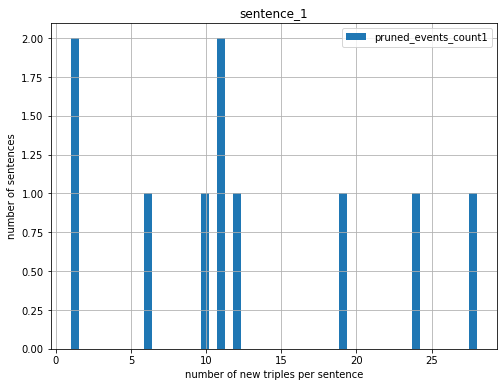

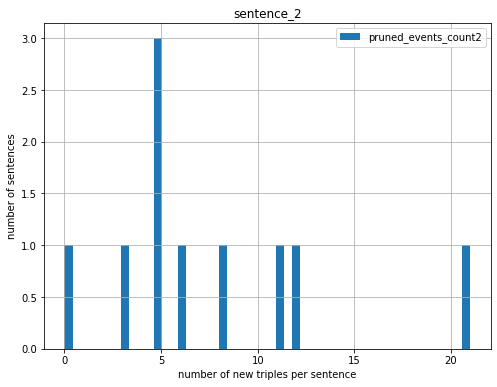

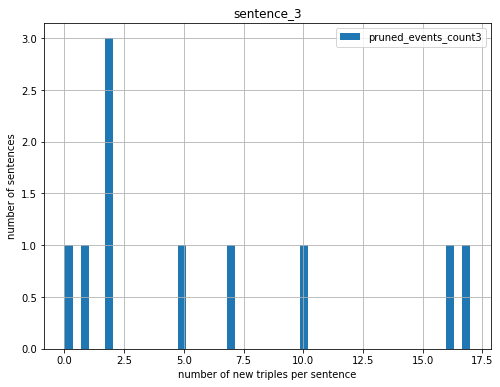

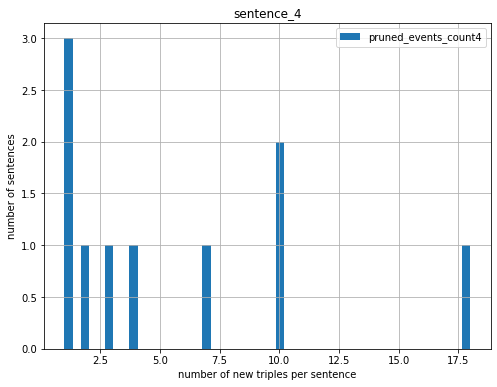

In [19]:
for f in range(1,5):
    hist = new_events_df.hist(bins=50, legend=True, figsize=(8,6),column=f'pruned_events_count{f}')

    plt.xlabel('number of new triples per sentence')
    plt.ylabel('number of sentences')
    plt.title(f'sentence_{f}')

In [20]:
new_events_df.sample(10)

Unnamed: 0                               storyid           storytitle  \
3           3  d173b7de-4611-4cdf-934c-912834755e41    The bad customer.   
5           5  5d5e7aeb-332f-4c8b-a3c3-44585501e493        Foolish Frank   
7           7  a4a9aaca-d3d4-46b4-807c-ef75aea68c56  Too sunny for Sunny   
4           4  af0fd5a4-de36-47ba-8aa2-e99d10986d7a        Being Patient   
0           0  9a51198e-96f1-42c3-b09d-a3e1e067d803       Overweight Kid   
8           8  8ddc9d26-d253-4eb3-b621-9a4e6d9c57e0      The Merry Widow   
6           6  bdceebb0-c6e8-417f-b6ae-741a0a71fcd3      Shark Adventure   
1           1  617e7ada-3878-488d-bd56-40695b91f053    The Bike Accident   
9           9  80ff5d8f-bcb1-437b-9da1-71c52997def2           Golf Cheat   
2           2  79b0da1f-e460-4173-ba58-8c9e2553c53a                Beach   

                                               sentence1  \
3                           Jane was working at a diner.   
5                          Frank had been drinking beer.   
7                      Sunny enjoyed going to the beach.   
4                       I was talking to my crush today.   
0                         Dan's parents were overweight.   
8  Sally was happy when her widowed mom found a new man.   
6                   Dave was in the Bahamas on vacation.   
1            Carrie had just learned how to ride a bike.   
9               Dan hit his golf ball and watched it go.   
2                Morgan enjoyed long walks on the beach.   

                                                           sentence2  \
3                     Suddenly, a customer barged up to the counter.   
5            He got a call from his girlfriend, asking where he was.   
7  As she stepped out of her car, she realized she forgot something.   
4            She continued to complain about guys flirting with her.   
0                                        Dan was overweight as well.   
8                  She discovered her siblings didn't feel the same.   
6                     He decided to go snorkeling on his second day.   
1                                 She didn't have a bike of her own.   
9              The ball bounced on the grass and into the sand trap.   
2               She and her boyfriend decided to go for a long walk.   

                                                              sentence3  \
3                  He began yelling about how long his food was taking.   
5                     Frank suddenly realized he had a date that night.   
7                     It was quite sunny and she forgot her sunglasses.   
4  I decided to agree with what she says and listened to her patiently.   
0                        The doctors told his parents it was unhealthy.   
8                Sally flew to visit her mom and her mom's new husband.   
6                             While snorkeling, he saw a cave up ahead.   
1                        Carrie would sneak rides on her sister's bike.   
9             Dan pretended that his ball actually landed on the green.   
2                    After walking for over a mile, something happened.   

                                                              sentence4  \
3                                        Jane didn't know how to react.   
5              Since Frank was already a bit drunk, he could not drive.   
7             Sunny got back into her car and heading towards the mall.   
4                              After I got home, I got a text from her.   
0                  His parents understood and decided to make a change.   
8  Although her mom was obviously in love, he was nothing like her dad.   
6    He went into the cave, and he was terrified when he found a shark!   
1                    She got nervous on a hill and crashed into a wall.   
9           His friends were not paying attention so they believed him.   
2                           Morgan decided to propose to her boyfriend.   

                                                            